Until now we have been working on similar set of data and they were all in grayscale.

We wil now move to complex datasets and imply complex models to get predictions. <br>
We will use CIFAR10 dataset which has 60k images which are all coloured and 32x32 pixels.

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

Now, we need to import the dataset in png form. We do it by downloading the dataset from <a href="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"> this site</a>. <br>
We will also use certain libraries to help download the dataset.

## Geting and Exploring Dataset 

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,".")

Using downloaded and verified file: .\cifar10.tgz


In [3]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

KeyboardInterrupt: 

In [4]:
# dataset has 50k training datsets and 10k testing datsets. To check:
data_dir = "./data/CIFAR10"
classes = os.listdir(data_dir+"/train")
os.listdir(data_dir), classes

(['test', 'train'],
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [5]:
# Each class of train has 5000 images and test has 1000 images. So, 5000+1000 = 6000. And 6000*10 = 60k images.
airplane_files = os.listdir(data_dir+"/train/airplane")
len(airplane_files), airplane_files[:3] 

(5000, ['0001.png', '0002.png', '0003.png'])

In [6]:
ship_files = os.listdir(data_dir+"/test/ship")
len(ship_files), airplane_files[:3] 

(1000, ['0001.png', '0002.png', '0003.png'])

## Loading Dataset images and converting to Tensors

We use torchvision to help us load the images and then convert them to tensors. 

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+"/train", transform=ToTensor())

In [9]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

Trying to view Images

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def show_example(img,label):
    print("label:",dataset.classes[label], label)
    plt.imshow(img.permute(1,2,0))

label: airplane 0


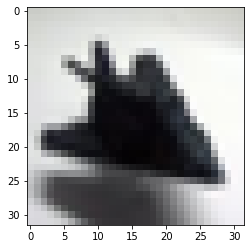

In [12]:
show_example(*dataset[0])

It is quite obv to see that this is quite difficult to determine even from the naked eye.

## Train and Validation Sets

We will be splitting the train set into train and validation sets again. But we will use a seed while randomizing indices so that we get the same train and test sets again, whenever we run it

In [13]:
import numpy as np

In [14]:
def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(n*val_pct)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [15]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
len(train_indices), train_indices[:2], len(val_indices), val_indices[:2]

(40000, array([39087, 30893]), 10000, array([33553,  9427]))

Making Samples and DataLoaders for our train and validation indices

In [16]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [17]:
batch_size = 100

train_sample = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sample)

val_sample = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size, sampler=val_sample)

Viewing a single batch of images from train_dl

In [18]:
from torchvision.utils import make_grid

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break

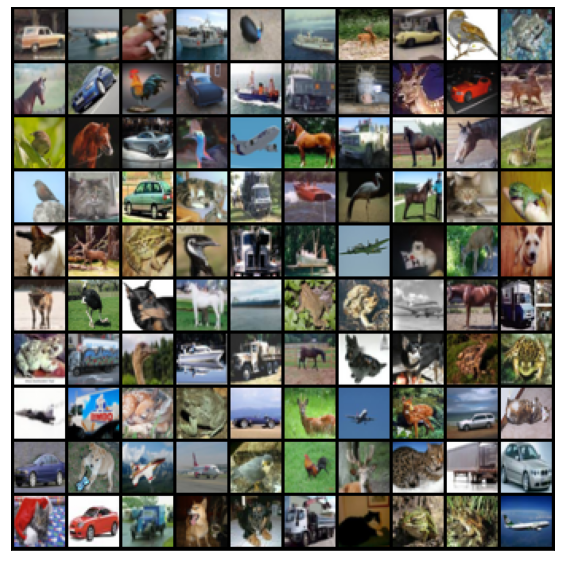

In [20]:
show_batch(train_dl)

## Model

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">



For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

#### Jargons and additional Info relating to Convolution
**Padding**: In this suppose we need to get the same size of output as our main matrix. To do this we pad the main matrix by one pixel on each side. This padding can be anything, from black or white to the edge colors. <br>
<center><img src="https://miro.medium.com/max/494/1*1okwhewf5KCtIPaFib4XaA.gif" style="max-width:300px"></center>

**Stride**: In this we know our kernel by default moves by one space. But if we want we can increase the number of steps it takes. This helps us in skipping parts of the main matrix. This enables us to have an output much less than the size of the original matrix. The idea of the stride is to skip some of the slide locations of the kernel. A stride of 1 means to pick slides a pixel apart, so basically every single slide, acting as a standard convolution. A stride of 2 means picking slides 2 pixels apart, skipping every other slide in the process, downsizing by roughly a factor of 2, a stride of 3 means skipping every 2 slides, downsizing roughly by factor 3, and so on. <br>
<center><img src="https://miro.medium.com/max/368/1*BMngs93_rm2_BpJFH2mS0Q.gif" style="max-width:300px"></center>

**Multi Channel Version**: Now usually, colour images have 3 channels, like rgb. To deal with it we give the input 3 kernels one for each channel they can have same or different weights. Different weights mean that there will be more emphasis on a particular colour channel. Then the output of all the individual kernel channels can be added to get a final channel. Then finally the bias can be added to give the final output channel.<br>
<center><img src="https://miro.medium.com/max/2000/1*8dx6nxpUh2JqvYWPadTwMQ.gif" style="max-width:300px"></center>
<center><img src="https://miro.medium.com/max/2000/1*CYB2dyR3EhFs1xNLK8ewiA.gif" style="max-width:300px"></center>
<center><img src="https://miro.medium.com/max/588/1*RYYucIh3U-YFxrIkyQKzRw.gif" style="max-width:300px"></center>



#### Advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [24]:
?nn.MaxPool2d

Init signature:
nn.MaxPool2d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
    return_indices: bool = False,
    ceil_mode: bool = False,
) -> None
Docstring:     
Applies a 2D max pooling over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
can be precisely described as:

.. math::
    \begin{aligned}
        out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
                                & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
                                               \text{stride[1]} \times w + n)
    \end{aligned}

If :attr:`padding` is non-zero, then the input is implicitly padded with negative infinity on both

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 8, 16, 16])


We can clearly see here, how it work. So basically the Conv2d part changes the input from 100,3,32,32 to 100,8,32,32 then the maxpool2d part changes the shape to 100,8,16,16.

Meaning that Conv2d changes the channels and MaxPool2d halves the height and width. (as stride is 2 and kernel is 2)

As the channel changes from 3 to 8, the matrix is no longer an images but rather a feature map. Then the MaxPool2d acts on this feature map. 

The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

So let us try to replicate this by adding so may layers that the image flattens into a vector shaped feature map.

In [42]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 16 x 16
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 8 x 8
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 4 x 4
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 2 x 2
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 1 x 1
    
    nn.Flatten(), # op => bs x 16 (flattens the feature map into a vector)
    nn.Linear(16,10) # op => bs x 10 
    # Final layer will be a fully connected layer that takes in 16 inputs and gives 10 outputs. 
)

In [43]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print("Out[0]:", out[0])
    print("Out[0] probabilities:", F.softmax(out[0]))
    _,pred = torch.max(F.softmax(out[0], dim=0),dim=0)
    print("Prediction Label:", pred, dataset.classes[pred])
    print("Actual Label:", dataset.classes[labels[0]])
    print("Actual Label:", labels[0])
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])
Out[0]: tensor([ 0.2061,  0.0636,  0.1511, -0.1396,  0.1301, -0.2788, -0.0638,  0.1929,
         0.1361,  0.0101], grad_fn=<SelectBackward0>)
Out[0] probabilities: tensor([0.1167, 0.1012, 0.1105, 0.0826, 0.1082, 0.0719, 0.0891, 0.1152, 0.1088,
        0.0959], grad_fn=<SoftmaxBackward0>)
Prediction Label: tensor(0) airplane
Actual Label: frog
Actual Label: tensor(6)


<ipython-input-43-4cf121502f4c>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("Out[0] probabilities:", F.softmax(out[0]))


In [46]:
images.shape

torch.Size([100, 3, 32, 32])

label: frog tensor(6)


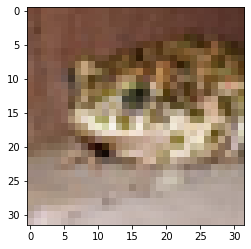

In [52]:
show_example(images[0], labels[0])

## Using GPU and moving Data to GPU

In [53]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [77]:
def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

In [78]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.device = device
        self.dl = dl
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)
    
    def __len__(self):
        return len(self.dl)

In [79]:
device = get_default_device()
device

device(type='cuda')

In [80]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

## Training the model
We will be reusing the loss_batch, evaluate and fit functions from before. We will also be using cross entropy as our loss function. 

In [81]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result    

In [86]:
def evaluate(model, loss_fn, valid_dl, metric = None):
    with torch.no_grad():
        result = [loss_batch(model, loss_fn, xb, yb, metric = metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*result)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums))/total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums))/total    
        
        return avg_loss, total, avg_metric

In [102]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn = None, lr=None, metric = None):
    train_losses, val_losses, val_metrics = [],[],[]
    
    if opt_fn is None:
        opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr) 
        
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt = opt)
        
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, _, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        if metric is None:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format (epoch+1, epochs, val_loss))
        else:
            print ('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format (epoch+1, epochs, val_loss, metric.__name__, val_metric))
            
    return train_losses, val_losses, val_metrics
        

In [84]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.sum(preds==labels).item()/len(preds)

In [88]:
val_loss, _, val_metric = evaluate(model, F.cross_entropy, valid_dl, accuracy)
print("Loss:", val_loss)
print("Accuracy:", val_metric)

Loss: 2.3155701565742492
Accuracy: 0.1009


Here also we can see that the initial accuracy is only 10%. This is fair as the weights and all are random for now, so a 10% accuracy makes sense from a guess point of view.

Let us try taking different optimizers to see if we can have higher accuracy in shorter time. 

In [100]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [103]:
history = fit(num_epochs, model,F.cross_entropy, train_dl, valid_dl, opt_fn=opt_fn, lr=lr,metric=accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], Loss: 1.6181, accuracy: 0.3809
Epoch [2/10], Loss: 1.4638, accuracy: 0.4552
Epoch [3/10], Loss: 1.3776, accuracy: 0.4963
Epoch [4/10], Loss: 1.3471, accuracy: 0.5152
Epoch [5/10], Loss: 1.2495, accuracy: 0.5534
Epoch [6/10], Loss: 1.2387, accuracy: 0.5557
Epoch [7/10], Loss: 1.2523, accuracy: 0.5570
Epoch [8/10], Loss: 1.2347, accuracy: 0.5647
Epoch [9/10], Loss: 1.2478, accuracy: 0.5536
Epoch [10/10], Loss: 1.1892, accuracy: 0.5760


We can see that the accuracy jumped from 10% to 38% in just 1 epoch. The curve flattens around 57%. 

It is still amazing that, such a complex problem can have a 60% accuracy rate. 

### Plotting 

In [105]:
def plot_metric(metric_values):
    plt.plot(metric_values,"-x")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

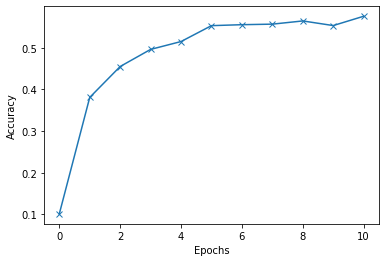

In [106]:
plot_metric([val_metric]+val_metrics)

Acc the graph it starts flattening out at about 58% and it is very unlikely that the accuracy will go further than 65%

Hence, we need a stronger model. This can be done by
1. Adding more convolution layers
2. Increasing number of channels in convolution layers

In [109]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

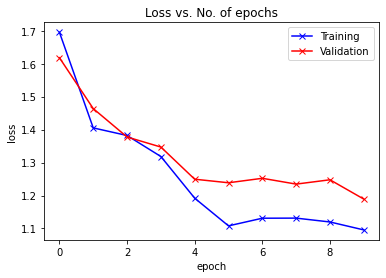

In [110]:
plot_losses(train_losses, val_losses)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase


## Testing with Individual Images

In [114]:
test_dataset = ImageFolder(data_dir+"/test",transform=ToTensor())

We will now make a single function that will help predict label for a single image

In [122]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    _,pred = torch.max(yb,dim=1)
    return dataset.classes[pred[0].item()]

Actual: airplane Predicted:  airplane


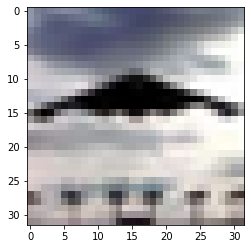

In [128]:
img,label = test_dataset[10]
plt.imshow(img.permute(1,2,0))
pred = predict_image(img, model)
print("Actual:",dataset.classes[label],"Predicted: ",pred)


Actual: airplane Predicted:  bird


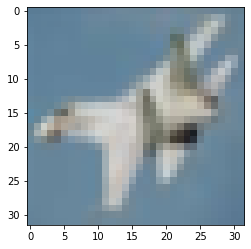

In [129]:
img,label = test_dataset[1]
plt.imshow(img.permute(1,2,0))
pred = predict_image(img, model)
print("Actual:",dataset.classes[label],"Predicted: ",pred)

Actual: automobile Predicted:  automobile


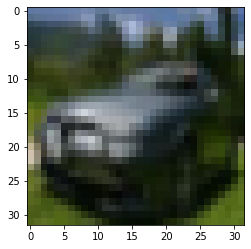

In [130]:
img,label = test_dataset[1241]
plt.imshow(img.permute(1,2,0))
pred = predict_image(img, model)
print("Actual:",dataset.classes[label],"Predicted: ",pred)

Checking losses and metrics on our test dl

In [131]:
test_dl = DataLoader(test_dataset, batch_size =batch_size)
test_dl = DeviceDataLoader(test_dl,device)

test_loss, _, test_metric = evaluate(model,F.cross_entropy,test_dl,accuracy)
print(test_loss, test_metric)

1.1811306828260422 0.5752


## Saving and Loading Model 

In [132]:
torch.save(model.state_dict(),"cifar10-cnn.pth")

In [140]:
model2 = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 16 x 16
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 8 x 8
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 4 x 4
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 2 x 2
    
    nn.Conv2d(16,16,kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # op => bs x 16 x 1 x 1
    
    nn.Flatten(), # op => bs x 16 (flattens the feature map into a vector)
    nn.Linear(16,10) # op => bs x 10 
    # Final layer will be a fully connected layer that takes in 16 inputs and gives 10 outputs. 
)

In [141]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>